In [ ]:
pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=d4aa8bae42c5b7aa8cf6a04355375547c5af4611056e333316b723acb0df1875
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [ ]:
import os
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from medmnist import PneumoniaMNIST, BreastMNIST
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Dataset selection
# To switch between datasets, replace 'PneumoniaMNIST' with 'BreastMNIST'
DatasetClass = PneumoniaMNIST  # Use BreastMNIST for the other dataset

# Transform pipeline
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalization for grayscale images
])

# Create the data directory if it doesn't exist
data_dir = "./data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Load the dataset, specifying the data directory
train_full = DatasetClass(split="train", transform=transform, download=True, root=data_dir)
test_full = DatasetClass(split="test", transform=transform, download=True, root=data_dir)

# Filter for binary classification (already binary for these datasets)
def filter_binary_classes(dataset):
    indices = [i for i, (image, label) in enumerate(dataset) if label in [0, 1]]
    return Subset(dataset, indices)

# Relabel binary classes (labels are already 0 and 1, so this step is redundant but included for consistency)
def relabel_binary_classes(dataset):
    for i, (image, label) in enumerate(dataset):
        dataset.dataset.labels[dataset.indices[i]] = int(label in [1])

train_filtered = filter_binary_classes(train_full)
test_filtered = filter_binary_classes(test_full)

relabel_binary_classes(train_filtered)
relabel_binary_classes(test_filtered)

# DataLoaders
train_loader = DataLoader(train_filtered, batch_size=64, shuffle=True)
test_loader = DataLoader(test_filtered, batch_size=64, shuffle=False)

# Define the binary classification model
class MedMNISTClassifier(nn.Module):
    def __init__(self, n_channels):
        super(MedMNISTClassifier, self).__init__()
        self.fc1 = nn.Linear(n_channels * 28 * 28, 50)
        self.silu = nn.SiLU()
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)  # Binary output
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the images
        x = self.fc1(x)
        x = self.silu(x)
        x = self.fc2(x)
        x = self.silu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Instantiate model, criterion, and optimizer
model = MedMNISTClassifier(n_channels=1)  # 1 channel for grayscale images
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

100%|██████████| 4.17M/4.17M [00:01<00:00, 3.62MB/s]


Using downloaded and verified file: ./data/pneumoniamnist.npz


In [ ]:

# Training loop
def train(model, loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in loader:
            labels = labels.float().unsqueeze(1)  # Convert to float and add a single dimension
            labels = labels.view(-1, 1)  # Ensure labels have shape [batch_size, 1]
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(loader)}")

# Evaluation
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            labels = labels.float().unsqueeze(1)  # Convert to float and add a single dimension
            labels = labels.view(-1, 1)  # Ensure labels have shape [batch_size, 1]
            outputs = model(images)
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    print(f"Accuracy: {100 * correct / total:.2f}%")

# Train and evaluate
train(model, train_loader, criterion, optimizer, epochs=30)
evaluate(model, test_loader)


Epoch 1/30, Loss: 0.2777812289627823
Epoch 2/30, Loss: 0.13251152931637056
Epoch 3/30, Loss: 0.11379790681137426
Epoch 4/30, Loss: 0.10926342934269358
Epoch 5/30, Loss: 0.10093951937616677
Epoch 6/30, Loss: 0.09386319294571877
Epoch 7/30, Loss: 0.09504014658867507
Epoch 8/30, Loss: 0.08570504822843783
Epoch 9/30, Loss: 0.08214359836829072
Epoch 10/30, Loss: 0.07478425851897211
Epoch 11/30, Loss: 0.07466032490687999
Epoch 12/30, Loss: 0.06628465180511812
Epoch 13/30, Loss: 0.06608201405411032
Epoch 14/30, Loss: 0.060464776234348885
Epoch 15/30, Loss: 0.06066660084635825
Epoch 16/30, Loss: 0.05485550656511977
Epoch 17/30, Loss: 0.05548743123025004
Epoch 18/30, Loss: 0.05297775586085344
Epoch 19/30, Loss: 0.045814038748299146
Epoch 20/30, Loss: 0.043489300321812766
Epoch 21/30, Loss: 0.05489468657587831
Epoch 22/30, Loss: 0.04311777401488979
Epoch 23/30, Loss: 0.03690155174086072
Epoch 24/30, Loss: 0.04050600714981556
Epoch 25/30, Loss: 0.030365384976706794
Epoch 26/30, Loss: 0.0283274495

In [ ]:
# save the model

torch.save(model.state_dict(), '/content/PneumoniaMNIST_model_part1.pth')

SiLU + Final layer Sigmoid

In [ ]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def fn(out_pre,model_dict_ls,li):
    if li == len(model_dict_ls)/2:
        return out_pre
    out_cur = []
    for i in range(len(model_dict_ls[2*li])):
        x = 0
        for j in range(len(out_pre)):
            x = x + out_pre[j]*model_dict_ls[2*li][i][j]
        if li == (len(model_dict_ls)/2)-1:
            out_cur.append(sigmoid(x+model_dict_ls[2*li+1][i]))
        else:
            out_cur.append((x+model_dict_ls[2*li+1][i])*sigmoid(x+model_dict_ls[2*li+1][i]))
    li+=1
    return fn(np.array(out_cur),model_dict_ls,li)

Helpers

In [ ]:

def get_square_slice_from_one_anchor(anchors,pad_dist=1,seed=None):
    """
    Given one vector as an anchor, takes a randomly oriented slice with the anchor at the center
    """
#     if seed is not None:
#         torch.manual_seed(seed)

    assert len(anchors) == 1

    centroid = anchors[0]

    z1 = torch.randn_like(anchors[0])
    z2 = torch.randn_like(anchors[0])

    u1 = z1
    u2 = z2 - (u1.T @ z2)/(u1.T @ u1)*u1

    dirs = torch.vstack([u1,u2])
    dirs /= torch.linalg.norm(dirs,dim=-1,keepdim=True)
    domain = torch.vstack([centroid+pad_dist*dirs,centroid-pad_dist*dirs])
    domain_poly = torch.vstack([domain,domain[:1]])

    return domain_poly



def get_square_slice_from_two_anchors(anchors,pad_dist=1,seed=-1):

    if not seed == -1: #None buggy for jit
        torch.manual_seed(seed)

    assert len(anchors) == 2

    centroid = torch.mean(anchors,dim=0)

    u1 = anchors[0] - centroid
    z = torch.randn_like(anchors[0])
    u2 = z - (u1.T @ z)/(u1.T @ u1)*u1

    dirs = torch.vstack([u1,u2])
    dirs /= torch.linalg.norm(dirs,dim=-1,keepdim=True)
    domain = torch.vstack([centroid+pad_dist*dirs,centroid-pad_dist*dirs])
    domain_poly = torch.vstack([domain,domain[:1]])

    return domain_poly

def get_square_domain_from_three_anchors(anchors,pad_dist=1,seed=-1):

    if not seed == -1: #None buggy for jit
        torch.manual_seed(seed)

    assert len(anchors) == 3

    centroid = torch.mean(anchors,dim=0)

    u1 = anchors[0] - centroid
    z = torch.randn_like(anchors[0])
    u2 = z - (u1.T @ z)/(u1.T @ u1)*u1

    dirs = torch.vstack([u1,u2])
    dirs /= torch.linalg.norm(dirs,dim=-1,keepdim=True)
    domain = torch.vstack([centroid+pad_dist*dirs,centroid-pad_dist*dirs])
    domain_poly = torch.vstack([domain,domain[:1]])

    return domain_poly

def get_square_bad_domain_from_three_anchors(anchors, pad_dist=1):
    """
    Generate a square domain in n-dimensional space based on three anchor points.
    The square lies in the plane defined by the three anchors, centered at their centroid,
    and with side length equal to pad_dist.
    """
    assert len(anchors) == 3, "Exactly three anchors are required."
    anchors = anchors#torch.stack(anchors)
    centroid = torch.mean(anchors, dim=0)

    # Compute vectors in the plane
    v1 = anchors[1] - anchors[0]
    v2 = anchors[2] - anchors[0]

    # Orthonormal basis via Gram-Schmidt process
    u1 = v1 / torch.norm(v1)
    v2_proj = v2 - torch.dot(v2, u1) * u1
    u2 = v2_proj / torch.norm(v2_proj)

    # Now u1 and u2 are orthonormal vectors in the plane

    # Define the square in the plane, centered at the centroid
    s = pad_dist / 2  # Half the side length

    # Define the four corners of the square
    corners = []
    for dx, dy in [(-s, -s), (-s, s), (s, s), (s, -s)]:
        point = centroid + dx * u1 + dy * u2
        corners.append(point)

    # Close the polygon
    domain_poly = torch.stack(corners + [corners[0]])

    return domain_poly


def get_proj_mat(domain):

    v1 = domain[1] - domain[0]
    v2 = domain[-2] - domain[0]

    v = torch.vstack([v1,v2])
    v /= torch.linalg.norm(v,dim=-1,keepdim=True)

    return torch.hstack([v.T,domain.mean(0,keepdim=True).T])

In [ ]:
samples = []
label_done = -1
for i, (data, labels) in enumerate(train_loader):
    if label_done != labels[0]:
        samples.append(data[0].flatten())  # Get the first data point from the batch
        label_done = labels[0]
        print(labels[0])
    if len(samples) == 2:
        break

stacked_samples = torch.stack(samples)
stacked_samples

tensor([1])
tensor([0])


tensor([[-0.7412, -0.7804, -0.7725,  ...,  0.3569,  0.3333,  0.3176],
        [ 0.0588,  0.2078,  0.3255,  ...,  0.2471,  0.3098,  0.3176]])

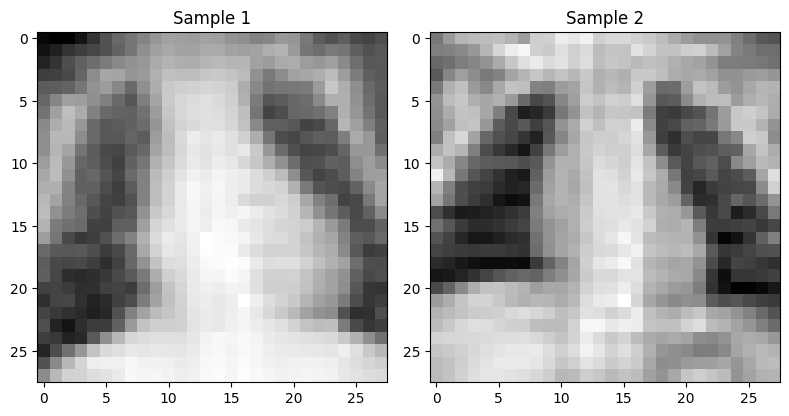

In [ ]:
import matplotlib.pyplot as plt

# Reshape the flattened tensors back into 28x28 images
image1 = stacked_samples[0].reshape(28, 28)
image2 = stacked_samples[1].reshape(28, 28)

# Create a figure and axes
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Display the first image
axes[0].imshow(image1, cmap='gray')
axes[0].set_title('Sample 1')

# Display the second image
axes[1].imshow(image2, cmap='gray')
axes[1].set_title('Sample 2')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
stacked_samples.shape

torch.Size([2, 784])

In [ ]:
other_samples = []
label_done = -1
for i, (data, labels) in enumerate(train_loader):
    if label_done != labels[0]:
        other_samples.append(data[0].flatten())  # Get the first data point from the batch
        label_done = labels[0]
        print(labels[0])
    if len(other_samples) == 2:
        break

stacked_other_samples = torch.stack(other_samples)
stacked_other_samples

tensor([1])
tensor([0])


tensor([[-0.4824, -0.4118, -0.4196,  ...,  0.3333,  0.3098,  0.2627],
        [-0.9922, -1.0000, -1.0000,  ...,  0.2706, -0.2471, -0.9294]])

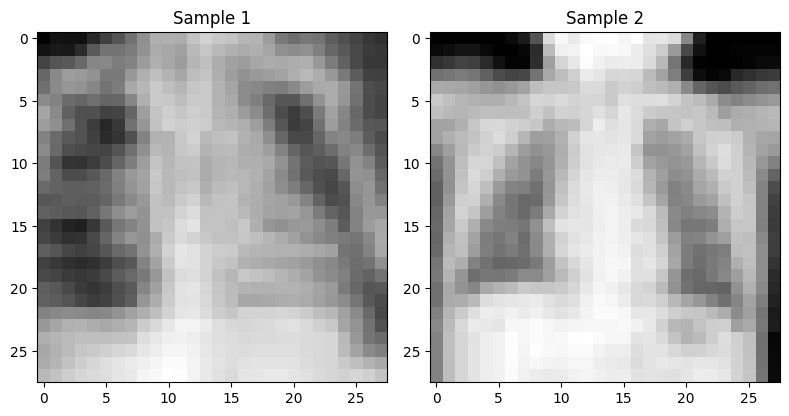

In [ ]:
import matplotlib.pyplot as plt

# Reshape the flattened tensors back into 28x28 images
image1 = stacked_other_samples[0].reshape(28, 28)
image2 = stacked_other_samples[1].reshape(28, 28)

# Create a figure and axes
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Display the first image
axes[0].imshow(image1, cmap='gray')
axes[0].set_title('Sample 1')

# Display the second image
axes[1].imshow(image2, cmap='gray')
axes[1].set_title('Sample 2')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Calculate Euclidean distance
def euclidean_distance(vector1, vector2):
    return torch.norm(vector1 - vector2)

# Assuming stacked_samples is already defined from the previous code
distance = euclidean_distance(stacked_other_samples[0], stacked_samples[0])

print(f"Euclidean distance between the two vectors: {distance}")

Euclidean distance between the two vectors: 6.057461738586426


In [ ]:
# Calculate Euclidean distance
def euclidean_distance(vector1, vector2):
    return torch.norm(vector1 - vector2)

# Assuming stacked_samples is already defined from the previous code
distance = euclidean_distance(stacked_other_samples[1], stacked_samples[1])

print(f"Euclidean distance between the two vectors: {distance}")

Euclidean distance between the two vectors: 11.510539054870605


In [ ]:
# Calculate Euclidean distance
def euclidean_distance(vector1, vector2):
    return torch.norm(vector1 - vector2)

# Assuming stacked_samples is already defined from the previous code
distance = euclidean_distance(stacked_other_samples[0], stacked_other_samples[1])

print(f"Euclidean distance between the two vectors: {distance}")

Euclidean distance between the two vectors: 9.851762771606445


In [ ]:
# Calculate Euclidean distance
def euclidean_distance(vector1, vector2):
    return torch.norm(vector1 - vector2)

# Assuming stacked_samples is already defined from the previous code
distance = euclidean_distance(stacked_samples[0], stacked_samples[1])

print(f"Euclidean distance between the two vectors: {distance}")

Euclidean distance between the two vectors: 9.292860984802246


In [ ]:
import numpy as np
from matplotlib.path import Path

def get_proj_mat(domain):
    """
    Compute the projection matrix P and translation vector x0 for projecting n-dimensional points to 2D.
    """
    v1 = domain[1] - domain[0]
    v2 = domain[2] - domain[0]

    # Orthonormal basis via Gram-Schmidt process
    e1 = v1 / np.linalg.norm(v1)
    v2_proj = v2 - np.dot(v2, e1) * e1
    e2 = v2_proj / np.linalg.norm(v2_proj)

    # Projection matrix from nD to 2D
    P = np.vstack([e1, e2])  # Shape: (2, n)

    # Translation vector (mean of the domain)
    x0 = domain.mean(axis=0)  # Shape: (n,)

    return P, x0

def project_points(points, P, x0):
    """
    Project n-dimensional points to 2D using projection matrix P and translation x0.
    """
    return (P @ (points - x0).T).T  # Shape: (N, 2)

def back_project_points(points_2d, P, x0):
    """
    Back-project 2D points to n-dimensional space using the pseudoinverse of P and translation x0.
    """
    P_pinv = np.linalg.pinv(P)  # Shape: (n, 2)
    return (P_pinv @ points_2d.T).T + x0  # Shape: (N, n)

def create_2d_arrays_for_hyperspace(domain):
    """
    Create 2D arrays for each dimension such that the square domain in hyperspace is represented
    as a 2D grid of points lying within the domain.
    """
    # Step 1: Compute the projection matrix and translation vector
    P, x0 = get_proj_mat(domain)  # P: (2, n), x0: (n,)

    # Step 2: Project the domain to 2D
    domain_2d = project_points(domain, P, x0)  # Shape: (m, 2)

    # Step 3: Create a 2D grid in the projected space
    x_min, x_max = domain_2d[:, 0].min(), domain_2d[:, 0].max()
    y_min, y_max = domain_2d[:, 1].min(), domain_2d[:, 1].max()
    x2 = np.linspace(x_min, x_max, 100)
    y2 = np.linspace(y_min, y_max, 100)
    X2, Y2 = np.meshgrid(x2, y2)  # Shapes: (100, 100)

    # Step 4: Flatten the grid and back-project to hyperspace
    grid_2d_flat = np.vstack([X2.ravel(), Y2.ravel()]).T  # Shape: (10000, 2)
    back_projected_points_flat = back_project_points(grid_2d_flat, P, x0)  # Shape: (10000, n)

    # Step 5: Filter points that lie inside the projected domain
    path = Path(domain_2d)
    inside_mask_flat = path.contains_points(grid_2d_flat)  # Shape: (10000,)

    # Step 6: Reshape back-projected points and mask to grid shape
    back_projected_points = back_projected_points_flat.reshape(X2.shape + (back_projected_points_flat.shape[1],))  # Shape: (100, 100, n)

    # Assuming grid_points is the array of shape (100, 100, n)
    unstacked_matrices = np.moveaxis(back_projected_points, -1, 0)  # Move the last axis to the first

    # Now unstacked_matrices is of shape (n, 100, 100)
    # You can unpack it into individual matrices
    dimension_matrices = list(unstacked_matrices)

    # Step 7: Set points outside the domain to NaN
    # inside_mask = inside_mask_flat.reshape(X2.shape)  # Shape: (100, 100)
    # back_projected_points[~inside_mask] = np.nan

    # The result is a 3D array where each layer along the last axis represents one dimension in hyperspace
    return dimension_matrices

# Calculate Euclidean distance
def euclidean_distance(vector1, vector2):
    return torch.norm(vector1 - vector2)

# Assuming stacked_samples is already defined from the previous code
distance = euclidean_distance(stacked_samples[0], stacked_samples[1])

print(f"Euclidean distance between the two vectors: {distance}")


# Example usage
domain = get_square_slice_from_two_anchors(stacked_samples,pad_dist=int(distance/2),seed=42).detach().numpy()
# domain = np.array([
#     [0.2572, 0.7355, 1.1020],
#     [1.5166, -1.7285, 0.5166],
#     [-0.7304, -2.5139, -1.0113],
#     [-1.9897, -0.0499, -0.4259],
#     [0.2572, 0.7355, 1.1020]  # Closing the polygon
# ])

grid_points = create_2d_arrays_for_hyperspace(domain)

print("Shape of the final 2D stacked array:", len(grid_points))


Euclidean distance between the two vectors: 9.292860984802246
Shape of the final 2D stacked array: 784


<ipython-input-7-c5823053cced>:38: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  u2 = z - (u1.T @ z)/(u1.T @ u1)*u1


For an extra 3

In [ ]:
import torch

def get_square_domain_from_three_anchors(anchors, pad_dist=1, seed=-1):
    if seed != -1:
        torch.manual_seed(seed)

    assert len(anchors) == 3

    # Compute the centroid of the anchors
    centroid = torch.mean(anchors, dim=0)

    # Vectors in the plane defined by the anchors
    u1 = anchors[1] - anchors[0]
    u2 = anchors[2] - anchors[0]

    # Orthonormalize u1 and u2 using the Gram-Schmidt process
    u1 = u1 / torch.linalg.norm(u1)
    u2 = u2 - torch.dot(u2, u1) * u1
    u2_norm = torch.linalg.norm(u2)
    if u2_norm < 1e-8:
        # If u2 is nearly zero vector after orthogonalization, generate a random vector orthogonal to u1
        u2 = torch.randn_like(u1)
        u2 = u2 - torch.dot(u2, u1) * u1
        u2_norm = torch.linalg.norm(u2)
    u2 = u2 / u2_norm

    # Directions (orthonormal basis) in the plane
    dirs = torch.stack([u1, u2])

    # Project the anchors onto the plane's coordinate system
    projections = (anchors - centroid) @ dirs.T  # Shape: (3, 2)

    # Find min and max projections along each direction
    min_proj = projections.min(dim=0).values - pad_dist
    max_proj = projections.max(dim=0).values + pad_dist

    # Adjust the ranges to make the domain a square
    ranges = max_proj - min_proj
    max_range = torch.max(ranges)
    for i in range(2):
        if ranges[i] < max_range:
            delta = max_range - ranges[i]
            min_proj[i] -= delta / 2
            max_proj[i] += delta / 2

    # Construct the square domain corners in the projection plane
    corners_proj = torch.tensor([
        [min_proj[0], min_proj[1]],
        [min_proj[0], max_proj[1]],
        [max_proj[0], max_proj[1]],
        [max_proj[0], min_proj[1]]
    ])

    # Map the corners back to the original hyperdimensional space
    corners = centroid + corners_proj @ dirs

    # Close the polygon by appending the first corner at the end
    domain_poly = torch.vstack([corners, corners[0].unsqueeze(0)])

    return domain_poly


In [ ]:
samples2 = samples.copy()
samples2.append(stacked_other_samples[0])
stacked_three_samples = torch.stack(samples2)

In [ ]:
stacked_three_samples

tensor([[-0.7412, -0.7804, -0.7725,  ...,  0.3569,  0.3333,  0.3176],
        [ 0.0588,  0.2078,  0.3255,  ...,  0.2471,  0.3098,  0.3176],
        [-0.4824, -0.4118, -0.4196,  ...,  0.3333,  0.3098,  0.2627]])

In [ ]:
domain

array([[-0.68552685, -0.71164846, -0.6961672 , ...,  0.3492246 ,
         0.33169663,  0.3176471 ],
       [-0.09092477, -0.10503066, -0.12981623, ...,  0.41565627,
         0.21249732,  0.1816703 ],
       [ 0.00317395,  0.13909951,  0.24910837, ...,  0.25469705,
         0.3114407 ,  0.3176471 ],
       [-0.59142816, -0.46751833, -0.31724256, ...,  0.18826537,
         0.43064   ,  0.4536239 ],
       [-0.68552685, -0.71164846, -0.6961672 , ...,  0.3492246 ,
         0.33169663,  0.3176471 ]], dtype=float32)

In [ ]:
distance

tensor(9.2929)

In [ ]:
# Assuming stacked_samples is already defined from the previous code
distance = euclidean_distance(stacked_samples[0], stacked_samples[1])
domain = get_square_domain_from_three_anchors(stacked_three_samples,pad_dist=int(distance*2/3),seed=42).detach().numpy()

grid_points = create_2d_arrays_for_hyperspace(domain)

print("Shape of the final 2D stacked array:", len(grid_points))

Shape of the final 2D stacked array: 784


In [ ]:
model_dict_ls = [np.array(ls.cpu()) for ls in list(model.state_dict().values())]
Z = fn(np.array(grid_points),model_dict_ls,0)[0]

In [ ]:
len(Z[Z>0.9])

6229

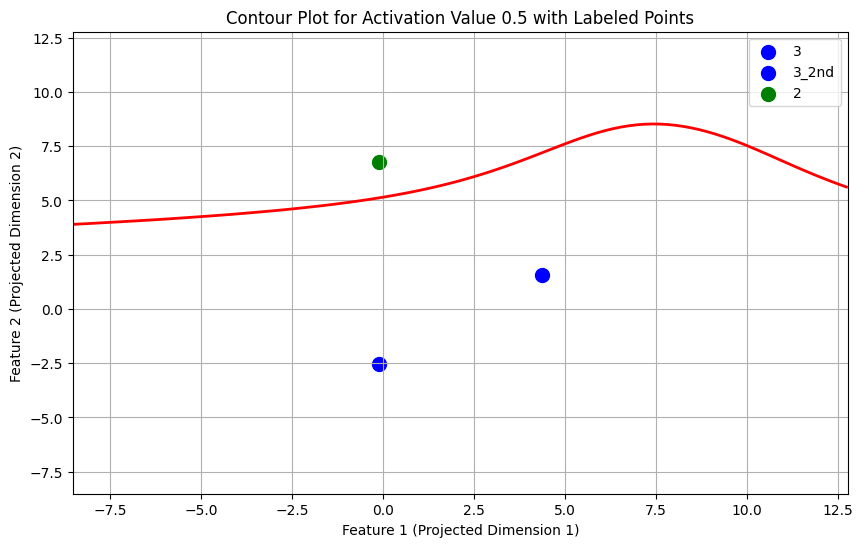

In [ ]:
# Step 1: Compute the projection matrix and translation vector
P, x0 = get_proj_mat(domain)  # P: (2, n), x0: (n,)

# Step 2: Project the domain to 2D
domain_2d = project_points(domain, P, x0)  # Shape: (m, 2)

# Step 3: Create a 2D grid in the projected space
x_min, x_max = domain_2d[:, 0].min(), domain_2d[:, 0].max()
y_min, y_max = domain_2d[:, 1].min(), domain_2d[:, 1].max()
x2 = np.linspace(x_min, x_max, 100)
y2 = np.linspace(y_min, y_max, 100)
X2, Y2 = np.meshgrid(x2, y2)  # Shapes: (100, 100)



# Define the labeled points
labeled_points = {
    "3": np.array(stacked_three_samples[0].detach().numpy()),
    "3_2nd": np.array(stacked_three_samples[2].detach().numpy()),
    "2": np.array(stacked_three_samples[1].detach().numpy()),
}

# Project the labeled points to 2D
projected_labeled_points = {label: project_points(point[None, :], P, x0)[0] for label, point in labeled_points.items()}

# Plot the contour for activation value 0.5
plt.figure(figsize=(10, 6))
contour = plt.contour(X2, Y2, Z, levels=[0.5], colors='red', linewidths=2)

# Plot the labeled points
for label, point in projected_labeled_points.items():
    if label in ["3" ,"3_2nd"]:
        plt.scatter(point[0], point[1], color='blue', label=label, s=100)  # Blue for inside
    elif label == "2":
        plt.scatter(point[0], point[1], color='green', label=label, s=100)  # Green for outside

# Add labels, title, and legend
plt.xlabel('Feature 1 (Projected Dimension 1)')
plt.ylabel('Feature 2 (Projected Dimension 2)')
plt.title('Contour Plot for Activation Value 0.5 with Labeled Points')
plt.legend()
plt.grid()
plt.show()


#Experiment 2

In [ ]:
samples = []
label_done = -1
for i, (data, labels) in enumerate(train_loader):
    if label_done != labels[0]:
        samples.append(data[0].flatten())  # Get the first data point from the batch
        label_done = labels[0]
        print(labels[0])
    if len(samples) == 2:
        break

stacked_samples = torch.stack(samples)
stacked_samples

tensor([1])
tensor([0])


tensor([[ 0.0196,  0.0588,  0.0824,  ...,  0.3255,  0.3098,  0.3098],
        [-0.4431, -0.5059, -0.9216,  ...,  0.3255,  0.0275, -0.5608]])

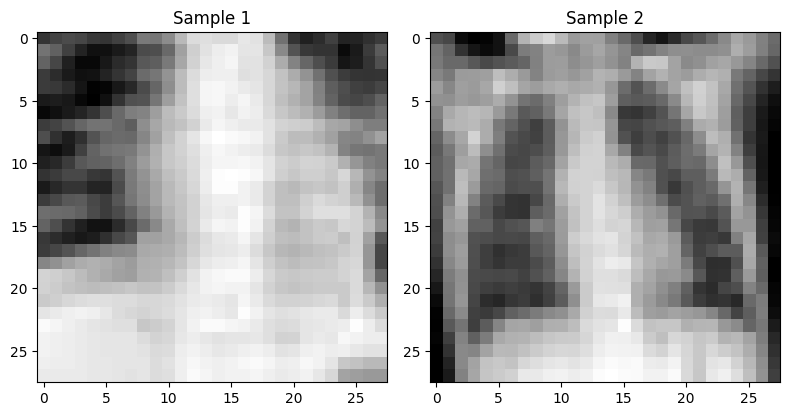

In [ ]:
import matplotlib.pyplot as plt

# Reshape the flattened tensors back into 28x28 images
image1 = stacked_samples[0].reshape(28, 28)
image2 = stacked_samples[1].reshape(28, 28)

# Create a figure and axes
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Display the first image
axes[0].imshow(image1, cmap='gray')
axes[0].set_title('Sample 1')

# Display the second image
axes[1].imshow(image2, cmap='gray')
axes[1].set_title('Sample 2')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
stacked_samples.shape

torch.Size([2, 784])

In [ ]:
other_samples = []
label_done = -1
for i, (data, labels) in enumerate(train_loader):
    if label_done != labels[0]:
        other_samples.append(data[0].flatten())  # Get the first data point from the batch
        label_done = labels[0]
        print(labels[0])
    if len(other_samples) == 2:
        break

stacked_other_samples = torch.stack(other_samples)
stacked_other_samples

tensor([1])
tensor([0])


tensor([[-0.1686, -0.1294, -0.0667,  ...,  0.3020,  0.2706,  0.2549],
        [-0.0902, -0.0196,  0.0275,  ...,  0.5608,  0.5294,  0.5137]])

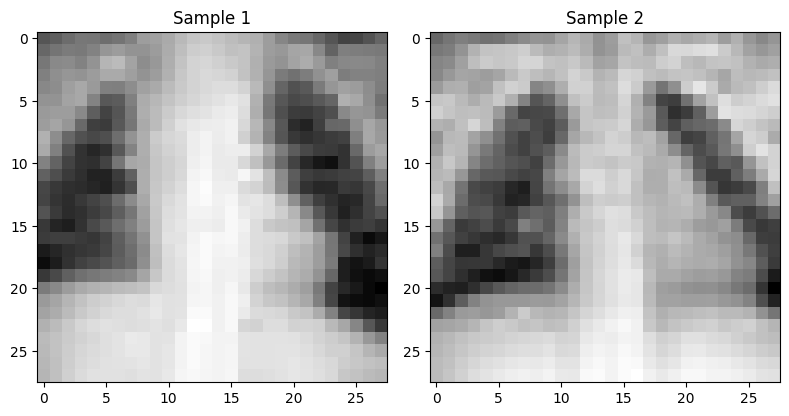

In [ ]:
import matplotlib.pyplot as plt

# Reshape the flattened tensors back into 28x28 images
image1 = stacked_other_samples[0].reshape(28, 28)
image2 = stacked_other_samples[1].reshape(28, 28)

# Create a figure and axes
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Display the first image
axes[0].imshow(image1, cmap='gray')
axes[0].set_title('Sample 1')

# Display the second image
axes[1].imshow(image2, cmap='gray')
axes[1].set_title('Sample 2')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Calculate Euclidean distance
def euclidean_distance(vector1, vector2):
    return torch.norm(vector1 - vector2)

# Assuming stacked_samples is already defined from the previous code
distance = euclidean_distance(stacked_other_samples[0], stacked_samples[0])

print(f"Euclidean distance between the two vectors: {distance}")

Euclidean distance between the two vectors: 9.083812713623047


In [ ]:
# Calculate Euclidean distance
def euclidean_distance(vector1, vector2):
    return torch.norm(vector1 - vector2)

# Assuming stacked_samples is already defined from the previous code
distance = euclidean_distance(stacked_other_samples[1], stacked_samples[1])

print(f"Euclidean distance between the two vectors: {distance}")

Euclidean distance between the two vectors: 13.008162498474121


In [ ]:
# Calculate Euclidean distance
def euclidean_distance(vector1, vector2):
    return torch.norm(vector1 - vector2)

# Assuming stacked_samples is already defined from the previous code
distance = euclidean_distance(stacked_other_samples[0], stacked_other_samples[1])

print(f"Euclidean distance between the two vectors: {distance}")

Euclidean distance between the two vectors: 6.849722385406494


In [ ]:
# Calculate Euclidean distance
def euclidean_distance(vector1, vector2):
    return torch.norm(vector1 - vector2)

# Assuming stacked_samples is already defined from the previous code
distance = euclidean_distance(stacked_samples[0], stacked_samples[1])

print(f"Euclidean distance between the two vectors: {distance}")

Euclidean distance between the two vectors: 16.741474151611328


In [ ]:
import numpy as np
from matplotlib.path import Path

def get_proj_mat(domain):
    """
    Compute the projection matrix P and translation vector x0 for projecting n-dimensional points to 2D.
    """
    v1 = domain[1] - domain[0]
    v2 = domain[2] - domain[0]

    # Orthonormal basis via Gram-Schmidt process
    e1 = v1 / np.linalg.norm(v1)
    v2_proj = v2 - np.dot(v2, e1) * e1
    e2 = v2_proj / np.linalg.norm(v2_proj)

    # Projection matrix from nD to 2D
    P = np.vstack([e1, e2])  # Shape: (2, n)

    # Translation vector (mean of the domain)
    x0 = domain.mean(axis=0)  # Shape: (n,)

    return P, x0

def project_points(points, P, x0):
    """
    Project n-dimensional points to 2D using projection matrix P and translation x0.
    """
    return (P @ (points - x0).T).T  # Shape: (N, 2)

def back_project_points(points_2d, P, x0):
    """
    Back-project 2D points to n-dimensional space using the pseudoinverse of P and translation x0.
    """
    P_pinv = np.linalg.pinv(P)  # Shape: (n, 2)
    return (P_pinv @ points_2d.T).T + x0  # Shape: (N, n)

def create_2d_arrays_for_hyperspace(domain):
    """
    Create 2D arrays for each dimension such that the square domain in hyperspace is represented
    as a 2D grid of points lying within the domain.
    """
    # Step 1: Compute the projection matrix and translation vector
    P, x0 = get_proj_mat(domain)  # P: (2, n), x0: (n,)

    # Step 2: Project the domain to 2D
    domain_2d = project_points(domain, P, x0)  # Shape: (m, 2)

    # Step 3: Create a 2D grid in the projected space
    x_min, x_max = domain_2d[:, 0].min(), domain_2d[:, 0].max()
    y_min, y_max = domain_2d[:, 1].min(), domain_2d[:, 1].max()
    x2 = np.linspace(x_min, x_max, 100)
    y2 = np.linspace(y_min, y_max, 100)
    X2, Y2 = np.meshgrid(x2, y2)  # Shapes: (100, 100)

    # Step 4: Flatten the grid and back-project to hyperspace
    grid_2d_flat = np.vstack([X2.ravel(), Y2.ravel()]).T  # Shape: (10000, 2)
    back_projected_points_flat = back_project_points(grid_2d_flat, P, x0)  # Shape: (10000, n)

    # Step 5: Filter points that lie inside the projected domain
    path = Path(domain_2d)
    inside_mask_flat = path.contains_points(grid_2d_flat)  # Shape: (10000,)

    # Step 6: Reshape back-projected points and mask to grid shape
    back_projected_points = back_projected_points_flat.reshape(X2.shape + (back_projected_points_flat.shape[1],))  # Shape: (100, 100, n)

    # Assuming grid_points is the array of shape (100, 100, n)
    unstacked_matrices = np.moveaxis(back_projected_points, -1, 0)  # Move the last axis to the first

    # Now unstacked_matrices is of shape (n, 100, 100)
    # You can unpack it into individual matrices
    dimension_matrices = list(unstacked_matrices)

    # Step 7: Set points outside the domain to NaN
    # inside_mask = inside_mask_flat.reshape(X2.shape)  # Shape: (100, 100)
    # back_projected_points[~inside_mask] = np.nan

    # The result is a 3D array where each layer along the last axis represents one dimension in hyperspace
    return dimension_matrices

# Calculate Euclidean distance
def euclidean_distance(vector1, vector2):
    return torch.norm(vector1 - vector2)

# Assuming stacked_samples is already defined from the previous code
distance = euclidean_distance(stacked_samples[0], stacked_samples[1])

print(f"Euclidean distance between the two vectors: {distance}")


# Example usage
domain = get_square_slice_from_two_anchors(stacked_samples,pad_dist=int(distance/2),seed=42).detach().numpy()
# domain = np.array([
#     [0.2572, 0.7355, 1.1020],
#     [1.5166, -1.7285, 0.5166],
#     [-0.7304, -2.5139, -1.0113],
#     [-1.9897, -0.0499, -0.4259],
#     [0.2572, 0.7355, 1.1020]  # Closing the polygon
# ])

grid_points = create_2d_arrays_for_hyperspace(domain)

print("Shape of the final 2D stacked array:", len(grid_points))


Euclidean distance between the two vectors: 16.741474151611328
Shape of the final 2D stacked array: 784


In [ ]:
import torch

def get_square_domain_from_three_anchors(anchors, pad_dist=1, seed=-1):
    if seed != -1:
        torch.manual_seed(seed)

    assert len(anchors) == 3

    # Compute the centroid of the anchors
    centroid = torch.mean(anchors, dim=0)

    # Vectors in the plane defined by the anchors
    u1 = anchors[1] - anchors[0]
    u2 = anchors[2] - anchors[0]

    # Orthonormalize u1 and u2 using the Gram-Schmidt process
    u1 = u1 / torch.linalg.norm(u1)
    u2 = u2 - torch.dot(u2, u1) * u1
    u2_norm = torch.linalg.norm(u2)
    if u2_norm < 1e-8:
        # If u2 is nearly zero vector after orthogonalization, generate a random vector orthogonal to u1
        u2 = torch.randn_like(u1)
        u2 = u2 - torch.dot(u2, u1) * u1
        u2_norm = torch.linalg.norm(u2)
    u2 = u2 / u2_norm

    # Directions (orthonormal basis) in the plane
    dirs = torch.stack([u1, u2])

    # Project the anchors onto the plane's coordinate system
    projections = (anchors - centroid) @ dirs.T  # Shape: (3, 2)

    # Find min and max projections along each direction
    min_proj = projections.min(dim=0).values - pad_dist
    max_proj = projections.max(dim=0).values + pad_dist

    # Adjust the ranges to make the domain a square
    ranges = max_proj - min_proj
    max_range = torch.max(ranges)
    for i in range(2):
        if ranges[i] < max_range:
            delta = max_range - ranges[i]
            min_proj[i] -= delta / 2
            max_proj[i] += delta / 2

    # Construct the square domain corners in the projection plane
    corners_proj = torch.tensor([
        [min_proj[0], min_proj[1]],
        [min_proj[0], max_proj[1]],
        [max_proj[0], max_proj[1]],
        [max_proj[0], min_proj[1]]
    ])

    # Map the corners back to the original hyperdimensional space
    corners = centroid + corners_proj @ dirs

    # Close the polygon by appending the first corner at the end
    domain_poly = torch.vstack([corners, corners[0].unsqueeze(0)])

    return domain_poly


In [ ]:
samples2 = samples.copy()
samples2.append(stacked_other_samples[0])
stacked_three_samples = torch.stack(samples2)
stacked_three_samples

tensor([[ 0.0196,  0.0588,  0.0824,  ...,  0.3255,  0.3098,  0.3098],
        [-0.4431, -0.5059, -0.9216,  ...,  0.3255,  0.0275, -0.5608],
        [-0.1686, -0.1294, -0.0667,  ...,  0.3020,  0.2706,  0.2549]])

In [ ]:
domain

array([[ 0.00936049,  0.04631826,  0.06012133, ...,  0.32549024,
         0.30355132,  0.29052493],
       [ 0.3326263 ,  0.19387439, -0.17569873, ...,  0.5453005 ,
        -0.05429001, -0.40846965],
       [-0.43288982, -0.49337706, -0.89933693, ...,  0.32549024,
         0.0337037 , -0.54150534],
       [-0.7561556 , -0.64093316, -0.6635169 , ...,  0.10567996,
         0.391545  ,  0.15748927],
       [ 0.00936049,  0.04631826,  0.06012133, ...,  0.32549024,
         0.30355132,  0.29052493]], dtype=float32)

In [ ]:
# Assuming stacked_samples is already defined from the previous code
distance = euclidean_distance(stacked_samples[0], stacked_samples[1])
domain = get_square_domain_from_three_anchors(stacked_three_samples,pad_dist=int(distance*2/3),seed=42).detach().numpy()

grid_points = create_2d_arrays_for_hyperspace(domain)

print("Shape of the final 2D stacked array:", len(grid_points))

Shape of the final 2D stacked array: 784


In [ ]:
model_dict_ls = [np.array(ls.cpu()) for ls in list(model.state_dict().values())]
Z = fn(np.array(grid_points),model_dict_ls,0)[0]

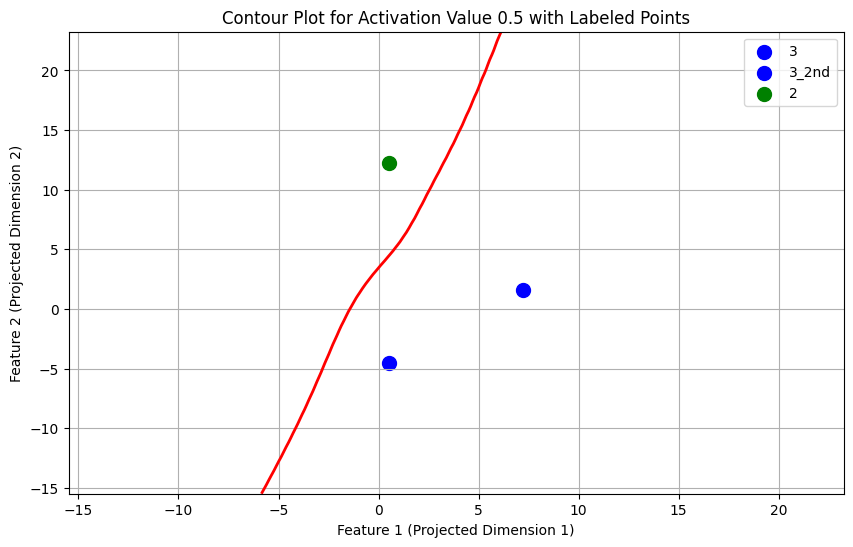

In [ ]:
# Step 1: Compute the projection matrix and translation vector
P, x0 = get_proj_mat(domain)  # P: (2, n), x0: (n,)

# Step 2: Project the domain to 2D
domain_2d = project_points(domain, P, x0)  # Shape: (m, 2)

# Step 3: Create a 2D grid in the projected space
x_min, x_max = domain_2d[:, 0].min(), domain_2d[:, 0].max()
y_min, y_max = domain_2d[:, 1].min(), domain_2d[:, 1].max()
x2 = np.linspace(x_min, x_max, 100)
y2 = np.linspace(y_min, y_max, 100)
X2, Y2 = np.meshgrid(x2, y2)  # Shapes: (100, 100)



# Define the labeled points
labeled_points = {
    "3": np.array(stacked_three_samples[0].detach().numpy()),
    "3_2nd": np.array(stacked_three_samples[2].detach().numpy()),
    "2": np.array(stacked_three_samples[1].detach().numpy()),
}

# Project the labeled points to 2D
projected_labeled_points = {label: project_points(point[None, :], P, x0)[0] for label, point in labeled_points.items()}

# Plot the contour for activation value 0.5
plt.figure(figsize=(10, 6))
contour = plt.contour(X2, Y2, Z, levels=[0.5], colors='red', linewidths=2)

# Plot the labeled points
for label, point in projected_labeled_points.items():
    if label in ["3" ,"3_2nd"]:
        plt.scatter(point[0], point[1], color='blue', label=label, s=100)  # Blue for inside
    elif label == "2":
        plt.scatter(point[0], point[1], color='green', label=label, s=100)  # Green for outside

# Add labels, title, and legend
plt.xlabel('Feature 1 (Projected Dimension 1)')
plt.ylabel('Feature 2 (Projected Dimension 2)')
plt.title('Contour Plot for Activation Value 0.5 with Labeled Points')
plt.legend()
plt.grid()
plt.show()


#Experiment 3

In [ ]:
samples = []
label_done = -1
for i, (data, labels) in enumerate(train_loader):
    if label_done != labels[0]:
        samples.append(data[0].flatten())  # Get the first data point from the batch
        label_done = labels[0]
        print(labels[0])
    if len(samples) == 2:
        break

stacked_samples = torch.stack(samples)
stacked_samples

tensor([1])
tensor([0])


tensor([[-0.1686, -0.1294, -0.0667,  ...,  0.3020,  0.2706,  0.2549],
        [-0.0902, -0.0196,  0.0275,  ...,  0.5608,  0.5294,  0.5137]])

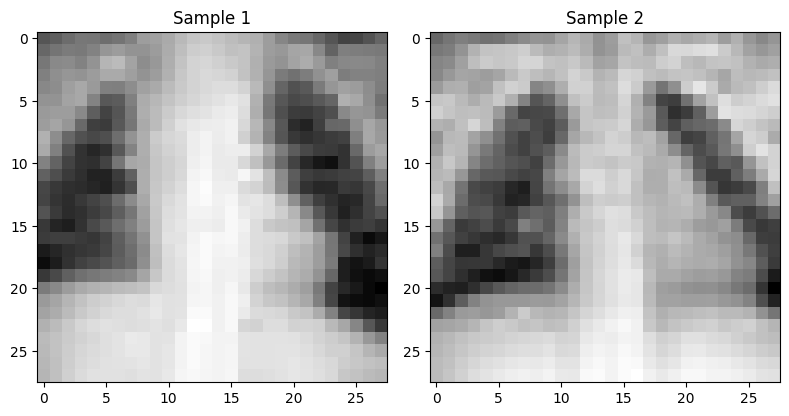

In [ ]:
import matplotlib.pyplot as plt

# Reshape the flattened tensors back into 28x28 images
image1 = stacked_samples[0].reshape(28, 28)
image2 = stacked_samples[1].reshape(28, 28)

# Create a figure and axes
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Display the first image
axes[0].imshow(image1, cmap='gray')
axes[0].set_title('Sample 1')

# Display the second image
axes[1].imshow(image2, cmap='gray')
axes[1].set_title('Sample 2')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
other_samples = []
label_done = -1
for i, (data, labels) in enumerate(train_loader):
    if label_done != labels[0]:
        other_samples.append(data[0].flatten())  # Get the first data point from the batch
        label_done = labels[0]
        print(labels[0])
    if len(other_samples) == 2:
        break

stacked_other_samples = torch.stack(other_samples)
stacked_other_samples

tensor([1])
tensor([0])


tensor([[-0.4980, -0.4431, -0.4902,  ...,  0.5137,  0.4902,  0.4745],
        [ 0.1608,  0.1216,  0.0824,  ...,  0.5529,  0.4667,  0.4196]])

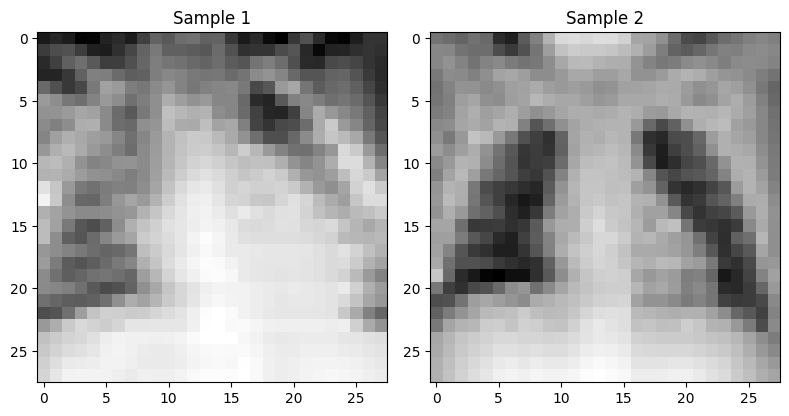

In [ ]:
import matplotlib.pyplot as plt

# Reshape the flattened tensors back into 28x28 images
image1 = stacked_other_samples[0].reshape(28, 28)
image2 = stacked_other_samples[1].reshape(28, 28)

# Create a figure and axes
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Display the first image
axes[0].imshow(image1, cmap='gray')
axes[0].set_title('Sample 1')

# Display the second image
axes[1].imshow(image2, cmap='gray')
axes[1].set_title('Sample 2')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Calculate Euclidean distance
def euclidean_distance(vector1, vector2):
    return torch.norm(vector1 - vector2)

# Assuming stacked_samples is already defined from the previous code
distance = euclidean_distance(stacked_other_samples[0], stacked_samples[0])

print(f"Euclidean distance between the two vectors: {distance}")

Euclidean distance between the two vectors: 8.62503433227539


In [ ]:
# Calculate Euclidean distance
def euclidean_distance(vector1, vector2):
    return torch.norm(vector1 - vector2)

# Assuming stacked_samples is already defined from the previous code
distance = euclidean_distance(stacked_other_samples[1], stacked_samples[1])

print(f"Euclidean distance between the two vectors: {distance}")

Euclidean distance between the two vectors: 7.5139875411987305


In [ ]:
# Calculate Euclidean distance
def euclidean_distance(vector1, vector2):
    return torch.norm(vector1 - vector2)

# Assuming stacked_samples is already defined from the previous code
distance = euclidean_distance(stacked_other_samples[0], stacked_other_samples[1])

print(f"Euclidean distance between the two vectors: {distance}")

Euclidean distance between the two vectors: 9.574958801269531


In [ ]:
# Calculate Euclidean distance
def euclidean_distance(vector1, vector2):
    return torch.norm(vector1 - vector2)

# Assuming stacked_samples is already defined from the previous code
distance = euclidean_distance(stacked_samples[0], stacked_samples[1])

print(f"Euclidean distance between the two vectors: {distance}")

Euclidean distance between the two vectors: 6.849722385406494


In [ ]:
import numpy as np
from matplotlib.path import Path

def get_proj_mat(domain):
    """
    Compute the projection matrix P and translation vector x0 for projecting n-dimensional points to 2D.
    """
    v1 = domain[1] - domain[0]
    v2 = domain[2] - domain[0]

    # Orthonormal basis via Gram-Schmidt process
    e1 = v1 / np.linalg.norm(v1)
    v2_proj = v2 - np.dot(v2, e1) * e1
    e2 = v2_proj / np.linalg.norm(v2_proj)

    # Projection matrix from nD to 2D
    P = np.vstack([e1, e2])  # Shape: (2, n)

    # Translation vector (mean of the domain)
    x0 = domain.mean(axis=0)  # Shape: (n,)

    return P, x0

def project_points(points, P, x0):
    """
    Project n-dimensional points to 2D using projection matrix P and translation x0.
    """
    return (P @ (points - x0).T).T  # Shape: (N, 2)

def back_project_points(points_2d, P, x0):
    """
    Back-project 2D points to n-dimensional space using the pseudoinverse of P and translation x0.
    """
    P_pinv = np.linalg.pinv(P)  # Shape: (n, 2)
    return (P_pinv @ points_2d.T).T + x0  # Shape: (N, n)

def create_2d_arrays_for_hyperspace(domain):
    """
    Create 2D arrays for each dimension such that the square domain in hyperspace is represented
    as a 2D grid of points lying within the domain.
    """
    # Step 1: Compute the projection matrix and translation vector
    P, x0 = get_proj_mat(domain)  # P: (2, n), x0: (n,)

    # Step 2: Project the domain to 2D
    domain_2d = project_points(domain, P, x0)  # Shape: (m, 2)

    # Step 3: Create a 2D grid in the projected space
    x_min, x_max = domain_2d[:, 0].min(), domain_2d[:, 0].max()
    y_min, y_max = domain_2d[:, 1].min(), domain_2d[:, 1].max()
    x2 = np.linspace(x_min, x_max, 100)
    y2 = np.linspace(y_min, y_max, 100)
    X2, Y2 = np.meshgrid(x2, y2)  # Shapes: (100, 100)

    # Step 4: Flatten the grid and back-project to hyperspace
    grid_2d_flat = np.vstack([X2.ravel(), Y2.ravel()]).T  # Shape: (10000, 2)
    back_projected_points_flat = back_project_points(grid_2d_flat, P, x0)  # Shape: (10000, n)

    # Step 5: Filter points that lie inside the projected domain
    path = Path(domain_2d)
    inside_mask_flat = path.contains_points(grid_2d_flat)  # Shape: (10000,)

    # Step 6: Reshape back-projected points and mask to grid shape
    back_projected_points = back_projected_points_flat.reshape(X2.shape + (back_projected_points_flat.shape[1],))  # Shape: (100, 100, n)

    # Assuming grid_points is the array of shape (100, 100, n)
    unstacked_matrices = np.moveaxis(back_projected_points, -1, 0)  # Move the last axis to the first

    # Now unstacked_matrices is of shape (n, 100, 100)
    # You can unpack it into individual matrices
    dimension_matrices = list(unstacked_matrices)

    # Step 7: Set points outside the domain to NaN
    # inside_mask = inside_mask_flat.reshape(X2.shape)  # Shape: (100, 100)
    # back_projected_points[~inside_mask] = np.nan

    # The result is a 3D array where each layer along the last axis represents one dimension in hyperspace
    return dimension_matrices

# Calculate Euclidean distance
def euclidean_distance(vector1, vector2):
    return torch.norm(vector1 - vector2)

# Assuming stacked_samples is already defined from the previous code
distance = euclidean_distance(stacked_samples[0], stacked_samples[1])

print(f"Euclidean distance between the two vectors: {distance}")


# Example usage
domain = get_square_slice_from_two_anchors(stacked_samples,pad_dist=int(distance/2),seed=42).detach().numpy()
# domain = np.array([
#     [0.2572, 0.7355, 1.1020],
#     [1.5166, -1.7285, 0.5166],
#     [-0.7304, -2.5139, -1.0113],
#     [-1.9897, -0.0499, -0.4259],
#     [0.2572, 0.7355, 1.1020]  # Closing the polygon
# ])

grid_points = create_2d_arrays_for_hyperspace(domain)

print("Shape of the final 2D stacked array:", len(grid_points))


Euclidean distance between the two vectors: 6.849722385406494
Shape of the final 2D stacked array: 784


In [ ]:
import torch

def get_square_domain_from_three_anchors(anchors, pad_dist=1, seed=-1):
    if seed != -1:
        torch.manual_seed(seed)

    assert len(anchors) == 3

    # Compute the centroid of the anchors
    centroid = torch.mean(anchors, dim=0)

    # Vectors in the plane defined by the anchors
    u1 = anchors[1] - anchors[0]
    u2 = anchors[2] - anchors[0]

    # Orthonormalize u1 and u2 using the Gram-Schmidt process
    u1 = u1 / torch.linalg.norm(u1)
    u2 = u2 - torch.dot(u2, u1) * u1
    u2_norm = torch.linalg.norm(u2)
    if u2_norm < 1e-8:
        # If u2 is nearly zero vector after orthogonalization, generate a random vector orthogonal to u1
        u2 = torch.randn_like(u1)
        u2 = u2 - torch.dot(u2, u1) * u1
        u2_norm = torch.linalg.norm(u2)
    u2 = u2 / u2_norm

    # Directions (orthonormal basis) in the plane
    dirs = torch.stack([u1, u2])

    # Project the anchors onto the plane's coordinate system
    projections = (anchors - centroid) @ dirs.T  # Shape: (3, 2)

    # Find min and max projections along each direction
    min_proj = projections.min(dim=0).values - pad_dist
    max_proj = projections.max(dim=0).values + pad_dist

    # Adjust the ranges to make the domain a square
    ranges = max_proj - min_proj
    max_range = torch.max(ranges)
    for i in range(2):
        if ranges[i] < max_range:
            delta = max_range - ranges[i]
            min_proj[i] -= delta / 2
            max_proj[i] += delta / 2

    # Construct the square domain corners in the projection plane
    corners_proj = torch.tensor([
        [min_proj[0], min_proj[1]],
        [min_proj[0], max_proj[1]],
        [max_proj[0], max_proj[1]],
        [max_proj[0], min_proj[1]]
    ])

    # Map the corners back to the original hyperdimensional space
    corners = centroid + corners_proj @ dirs

    # Close the polygon by appending the first corner at the end
    domain_poly = torch.vstack([corners, corners[0].unsqueeze(0)])

    return domain_poly


In [ ]:
samples2 = samples.copy()
samples2.append(stacked_other_samples[0])
stacked_three_samples = torch.stack(samples2)
stacked_three_samples

tensor([[-0.1686, -0.1294, -0.0667,  ...,  0.3020,  0.2706,  0.2549],
        [-0.0902, -0.0196,  0.0275,  ...,  0.5608,  0.5294,  0.5137],
        [-0.4980, -0.4431, -0.4902,  ...,  0.5137,  0.4902,  0.4745]])

In [ ]:
# Assuming stacked_samples is already defined from the previous code
distance = euclidean_distance(stacked_samples[0], stacked_samples[1])
domain = get_square_domain_from_three_anchors(stacked_three_samples,pad_dist=int(distance*2/3),seed=42).detach().numpy()

grid_points = create_2d_arrays_for_hyperspace(domain)

print("Shape of the final 2D stacked array:", len(grid_points))

Shape of the final 2D stacked array: 784


In [ ]:
model_dict_ls = [np.array(ls.cpu()) for ls in list(model.state_dict().values())]
Z = fn(np.array(grid_points),model_dict_ls,0)[0]

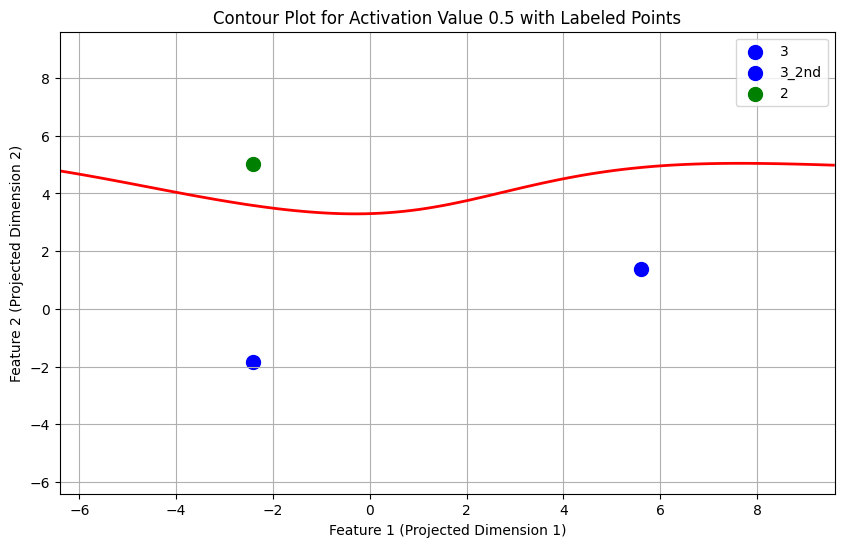

In [ ]:
# Step 1: Compute the projection matrix and translation vector
P, x0 = get_proj_mat(domain)  # P: (2, n), x0: (n,)

# Step 2: Project the domain to 2D
domain_2d = project_points(domain, P, x0)  # Shape: (m, 2)

# Step 3: Create a 2D grid in the projected space
x_min, x_max = domain_2d[:, 0].min(), domain_2d[:, 0].max()
y_min, y_max = domain_2d[:, 1].min(), domain_2d[:, 1].max()
x2 = np.linspace(x_min, x_max, 100)
y2 = np.linspace(y_min, y_max, 100)
X2, Y2 = np.meshgrid(x2, y2)  # Shapes: (100, 100)



# Define the labeled points
labeled_points = {
    "3": np.array(stacked_three_samples[0].detach().numpy()),
    "3_2nd": np.array(stacked_three_samples[2].detach().numpy()),
    "2": np.array(stacked_three_samples[1].detach().numpy()),
}

# Project the labeled points to 2D
projected_labeled_points = {label: project_points(point[None, :], P, x0)[0] for label, point in labeled_points.items()}

# Plot the contour for activation value 0.5
plt.figure(figsize=(10, 6))
contour = plt.contour(X2, Y2, Z, levels=[0.5], colors='red', linewidths=2)

# Plot the labeled points
for label, point in projected_labeled_points.items():
    if label in ["3" ,"3_2nd"]:
        plt.scatter(point[0], point[1], color='blue', label=label, s=100)  # Blue for inside
    elif label == "2":
        plt.scatter(point[0], point[1], color='green', label=label, s=100)  # Green for outside

# Add labels, title, and legend
plt.xlabel('Feature 1 (Projected Dimension 1)')
plt.ylabel('Feature 2 (Projected Dimension 2)')
plt.title('Contour Plot for Activation Value 0.5 with Labeled Points')
plt.legend()
plt.grid()
plt.show()
